# Covid-19 Monitoring Notebook 
The Johns Hopkins Center for Systems Science and Engineering (CSSE) operates a [dashboard](https://systems.jhu.edu/research/public-health/ncov/) on the Web to follow the covid-19 cases and deaths all over the world. The data is collected on a daily basis from different sources and has been made available on [Github](https://github.com/CSSEGISandData/COVID-19). This is a selection for some European countries. The observed cases are shown for each country and then merged together for comparison.

[Italy](#Italy)  
[Germany](#Germany)  
[France](#France)  
[Spain](#Spain)  
[Comparisons](#Comparisons)  
[Summary](#Summary)

***
## Definitions
We follow the definitions for measures as given in the book by Bonita et al., [Basic Epidemiology, 2nd ed.](https://apps.who.int/iris/handle/10665/43541) available in different languages from the World Health Organization website. 

***Confirmed Case*** according to the European Centre for Disease Prevention and Control, a person with laboratory confirmation of virus causing COVID-19 infection, irrespective of clinical signs and symptoms.

***Cumulative Incidence*** is the number of new cases of the disease during a specified period of time in a specific healthy population. It represents the risk of becoming ill. In this notebook the period of time considered is from the onset of the disease  up to the last update report and the population at risk is the entire population of a country. The cumulative incidence is computed as the ratio between the cumulative confirmed infections and the country's population, assuming that a vast majority is still healthy, per 100.000 people (see Bonita et al., p.21). If, at any given time point t, C(t) denotes the cumulative confirmed infections and P(t) denotes the population at risk, that we assume for the time being to be the entire population of a country, the cumulative incidence CI(t) is

$$CI(t) = \frac{C(t)}{P(t)}\times100.000$$

***Case Fatality*** represents the ratio between the number of people who have died from the infection and the number of people who have been confirmed to be infected, expressed as a percentage. In this notebook it is computed as the ratio between the cumulative deaths and the cumulative confirmed infections (see Bonita et al., p.22). If, at any given time point t, C(t) denotes the cumulative confirmed infections, as before, and D(t) denotes the cumulative number of deaths, the case fatality CF(t) is 

$$CF(t) = \frac{D(t)}{C(t)}\times100$$

This is a crude estimation of the case fatality that does not take into account the time delay that occurs between the confirmation of an infection and its outcome, being a recovery or a death.  

***Doubling Time*** is the time it takes for a parameter to double in value. In this notebook it is computed for the cumulative confirmed infections by finding the day, before the last one, in which the value was a half. The longer time it takes for the number of infections to double, and the higher is the value of the doubling time, the better.  

***Basic Reproduction Number $R_0$*** is the expected number of secondary cases generated by one infected individual in a population where all individuals are susceptibles, i.e. no one is immunized because of recovery or vaccination. According to the [Susceptible-Infectious-Recovered](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) (SIR) deterministic model, it is possible to predict the number of infections $I(t)$ over the time $t$, at the early stage of an outbreak, using the equation  

$$I(t) = I_0\exp^{\frac{R_0 - 1}{d} t}$$

where $d$ represents the average duration of the infection for an individual. From this equation it can be seen that, if $R_0 > 1$ there will be an epidemic outbreak. A rough estimation of $R_0$ can be computed using the doubling time $\Delta t_2$ such that  


$$\frac{I(t)}{I_0} = \exp^{\frac{R_0 - 1}{d} \Delta t_2} = 2$$


taking the logarithm of both sides we have

$$\frac{R_0 - 1}{d} \Delta t_2 = log(2)$$


and finally 

$$ R_0 = log(2) \frac{d}{\Delta t_2} + 1$$

Assuming a duration of the infection of, e.g. $d = 30$ days from the onset, few days before the symptoms appear till complete recovery, and computing the doubling time from the data of confirmed infections, as soon as they are available, we can get a rough estimation of $R_0$. The basic reproduction number $R_0$ can be used to estimate if and how quickly an infection can spread in a population. Since in the SIR model $R_0$ depends on the rate of contacts that people have, it is clear that social distance is an important action to prevent the spread of the infection, if enacted at its onset. One limitation of $R_0$, computed from the confirmed infection, is that it can underestimate its real value since the majority of the cases are individuals who had only mild or even no symptoms at all.


## References

* [Report of the WHO-China Joint Mission on Coronavirus Disease 2019 (COVID-19)](https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)
* [Riou et al. - Adjusted age-specific case fatality ratio during the COVID-19 epidemic in Hubei, China, January and February 2020](https://www.medrxiv.org/content/10.1101/2020.03.04.20031104v1)
* [Russell et al. - Using a delay-adjusted case fatality ratio to estimate under-reporting](https://cmmid.github.io/topics/covid19/severity/global_cfr_estimates.html) 
* [Verity et al. - Estimates of severity of COVID-19 disease](https://www.medrxiv.org/content/10.1101/2020.03.09.20033357v1)
* [Wu et al. - Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20);30260-9/fulltext)
* [Liu et al. - Measurability of the epidemic reproduction number in data-driven contact networks](https://www.ncbi.nlm.nih.gov/pubmed/30463945)

## Software 
This notebook uses python as programming language, and some libraries, pandas for data handling and matplotlib for data visualization. The covid-19 data is handled as pandas time series and is visualized as simple line plot with the dates as x dimension and the observation as y dimension. Bar charts cannot use directly pandas' time series objects so two separated arrays are created from the time series to be used as input for bar charts, days and observations. The solution used may change if better libraries are discovered.

<a href="https://colab.research.google.com/github/luigiselmi/datascience/blob/master/python/covid19-monitoring-notebook.ipynb" target="_blank"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" width="117" height="20"></a>


In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns; sns.set()
import warnings
#warnings.filterwarnings('ignore')
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
print("pandas version: %s"%pd.__version__)

python version: 3.7.4
numpy version: 1.16.5
pandas version: 0.25.1


### Functions
A collection of functions that are not directly available in the python libraries.

In [288]:
def doubling_time(timeseries):
    """Computes the number of days for the values to double since the last day"""
    dt = pd.Series(index = timeseries.index)
    for last_day in timeseries.sort_index(ascending=False).index.strftime('%Y-%m-%d'): 
        for d in timeseries.sort_index(ascending=False).index: # sorts the dates in descending order
            if timeseries[last_day] - timeseries[d] * 2 >= 0:
                dt[last_day] = (pd.to_datetime(last_day) - d).days 
                break
    return dt.fillna(0).astype('int32')

### Data Structures

In [289]:
countries = ['Italy', 'Germany', 'France', 'Spain']
summary = pd.DataFrame(columns = ['Confirmed Infections', 'Doubling Time', 'Incidence', 'Deaths', 'Case Fatality'], 
                       index = countries)

***
## Data sources

### Johns Hopkins CSSE - Covid-19 Epidemiological data 

In [290]:
#url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
confirmed_dataset = pd.read_csv(url_confirmed) 
#url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths_dataset = pd.read_csv(url_deaths)
# creates an index of dates
start_date_index = 43 # starts from March 1st
dates_array = [date for date in confirmed_dataset.columns[start_date_index:]] # removes first columns that are not dates
dates_index = pd.to_datetime(dates_array)
last_day = dates_index[dates_index.size - 1].strftime('%Y-%m-%d')
start_day = dates_index[0].strftime('%Y-%m-%d')
week_days = pd.date_range(start_day,last_day, freq='W')

### Eurostat population data

In [291]:
url_population = "https://raw.githubusercontent.com/luigiselmi/datascience/master/python/covid19/data/eurostat_population_by_age_2019.csv"
population = pd.read_csv(url_population)

### Eurostat health care facilities
Number of available beds (2017)

In [292]:
url_beds = "https://raw.githubusercontent.com/luigiselmi/datascience/master/python/covid19/data/eurostat_hlth_rs_bds.csv"
beds = pd.read_csv(url_beds)

***
## Italy

In [293]:
population_it = population[population['country_code'] == 'IT']['total'].values[0]
print("Italy's population (2019) = %d"%population_it)

Italy's population (2019) = 60359546


In [294]:
beds_it = beds[beds['country_code'] == 'IT']['2017'].values[0]
print("Italy's public and private health care facilities, available beds in 2017 = %d"%beds_it)

Italy's public and private health care facilities, available beds in 2017 = 192548


In [295]:
people_per_bed_it =  population_it / beds_it 
print("Number of persons per bed = %.0f"%people_per_bed_it)

Number of persons per bed = 313


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [296]:
confirmed_dataset_it = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Italy']
confirmed_dataset_values_it = [confirmed for confirmed in confirmed_dataset_it.values[0][start_date_index:]] 
confirmed_infections_it = pd.Series(confirmed_dataset_values_it, index=dates_index)
confirmed_infections_it['2020-09-01':]

2020-09-01    270189
2020-09-02    271515
2020-09-03    272912
2020-09-04    274644
2020-09-05    276338
2020-09-06    277634
2020-09-07    278784
2020-09-08    280153
2020-09-09    281583
2020-09-10    283180
2020-09-11    284796
2020-09-12    286297
2020-09-13    287753
2020-09-14    288761
2020-09-15    289990
2020-09-16    291442
2020-09-17    293025
2020-09-18    294932
2020-09-19    296569
2020-09-20    298156
2020-09-21    299506
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [297]:
confirmed_per_day_array_it = [confirmed_infections_it[d++1] - confirmed_infections_it[d] for d in range(dates_index.size - 1)]
confirmed_per_day_it = pd.Series(confirmed_per_day_array_it, index=dates_index[1:])
confirmed_per_day_it['2020-09-01':]

2020-09-01     975
2020-09-02    1326
2020-09-03    1397
2020-09-04    1732
2020-09-05    1694
2020-09-06    1296
2020-09-07    1150
2020-09-08    1369
2020-09-09    1430
2020-09-10    1597
2020-09-11    1616
2020-09-12    1501
2020-09-13    1456
2020-09-14    1008
2020-09-15    1229
2020-09-16    1452
2020-09-17    1583
2020-09-18    1907
2020-09-19    1637
2020-09-20    1587
2020-09-21    1350
dtype: int64

<BarContainer object of 204 artists>

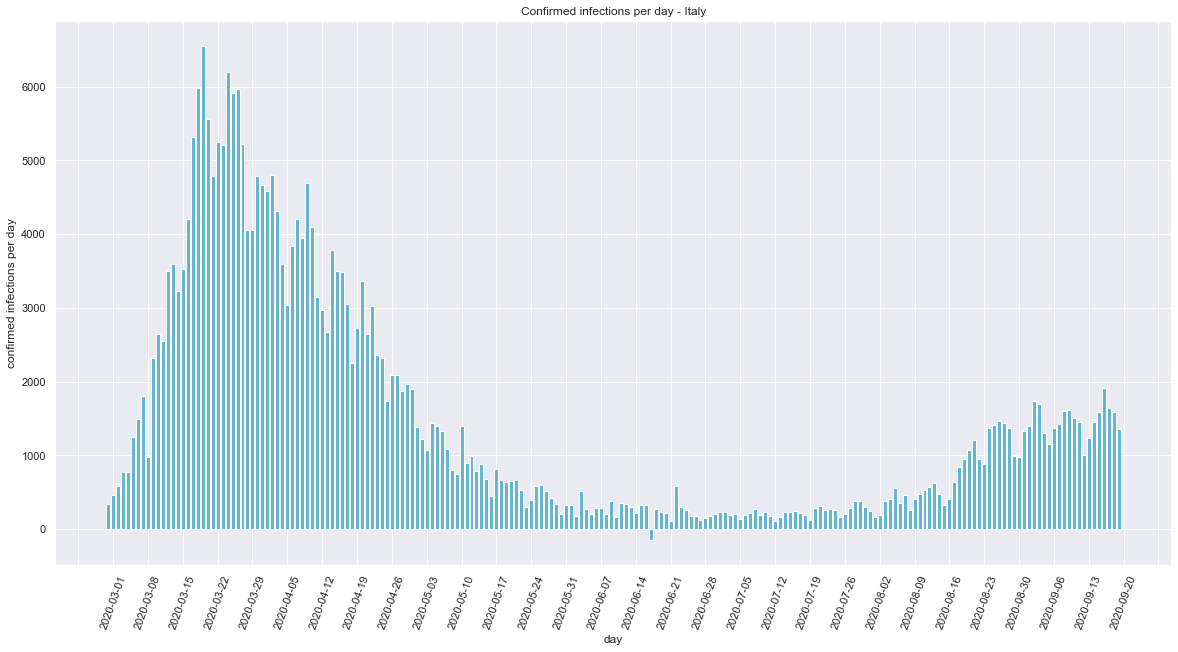

In [298]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [299]:
deaths_dataset_it = deaths_dataset[deaths_dataset['Country/Region'] == 'Italy']
deaths_dataset_values_it = [death for death in deaths_dataset_it.values[0][start_date_index:]]
deaths_it = pd.Series(deaths_dataset_values_it, index=dates_index)
deaths_it['2020-09-01':]

2020-09-01    35491
2020-09-02    35497
2020-09-03    35507
2020-09-04    35518
2020-09-05    35534
2020-09-06    35541
2020-09-07    35553
2020-09-08    35563
2020-09-09    35577
2020-09-10    35587
2020-09-11    35597
2020-09-12    35603
2020-09-13    35610
2020-09-14    35624
2020-09-15    35633
2020-09-16    35645
2020-09-17    35658
2020-09-18    35668
2020-09-19    35692
2020-09-20    35707
2020-09-21    35724
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [300]:
deaths_per_day_array_it = [deaths_it[d++1] - deaths_it[d] for d in range(dates_index.size - 1)]
deaths_per_day_it = pd.Series(deaths_per_day_array_it, index=dates_index[1:])
deaths_per_day_it['2020-09-01':]

2020-09-01     8
2020-09-02     6
2020-09-03    10
2020-09-04    11
2020-09-05    16
2020-09-06     7
2020-09-07    12
2020-09-08    10
2020-09-09    14
2020-09-10    10
2020-09-11    10
2020-09-12     6
2020-09-13     7
2020-09-14    14
2020-09-15     9
2020-09-16    12
2020-09-17    13
2020-09-18    10
2020-09-19    24
2020-09-20    15
2020-09-21    17
dtype: int64

<BarContainer object of 204 artists>

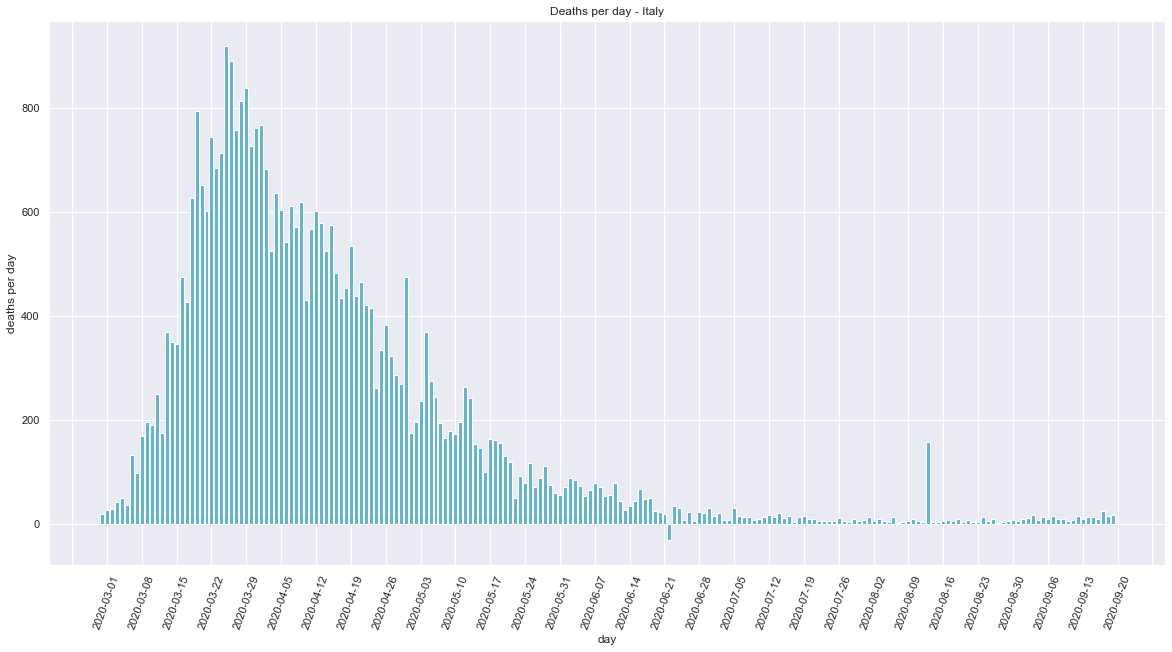

In [301]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Italy")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [302]:
doubling_time_it = doubling_time(confirmed_infections_it)[last_day]
summary['Doubling Time']['Italy'] = doubling_time(confirmed_infections_it)[last_day]
print("Italy's cumulative infections doubling time = %.0d days"%doubling_time_it)

Italy's cumulative infections doubling time = 164 days


### Cumulative incidence

In [303]:
cumulative_incidence_it = (confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000
summary['Incidence']['Italy'] = round((confirmed_infections_it[confirmed_infections_it.size - 1] / population_it) * 100000)
print("Italy's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_it)

Italy's cumulative incidence = 496 per 100.000 persons


### Case fatality

In [304]:
last_infections_it = confirmed_infections_it[confirmed_infections_it.size - 1]
last_deaths_it = deaths_it[deaths_it.size - 1]
last_case_fatality_it = (last_deaths_it / last_infections_it) * 100
summary['Confirmed Infections']['Italy'] = confirmed_infections_it[confirmed_infections_it.size - 1]
summary['Deaths']['Italy'] = deaths_it[deaths_it.size - 1]
summary['Case Fatality']['Italy'] = round((deaths_it[deaths_it.size - 1] / confirmed_infections_it[confirmed_infections_it.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_it, last_infections_it, last_case_fatality_it))  

Last report day: 2020-09-21 
deaths: 35724; cumulative confirmed infections: 299506; case fatality 11.93 %


In [305]:
cf_array_it = [(deaths_it[d] / confirmed_infections_it[d]) * 100 for d in range(dates_index.size)]
cf_it = pd.Series(cf_array_it, index=dates_index)

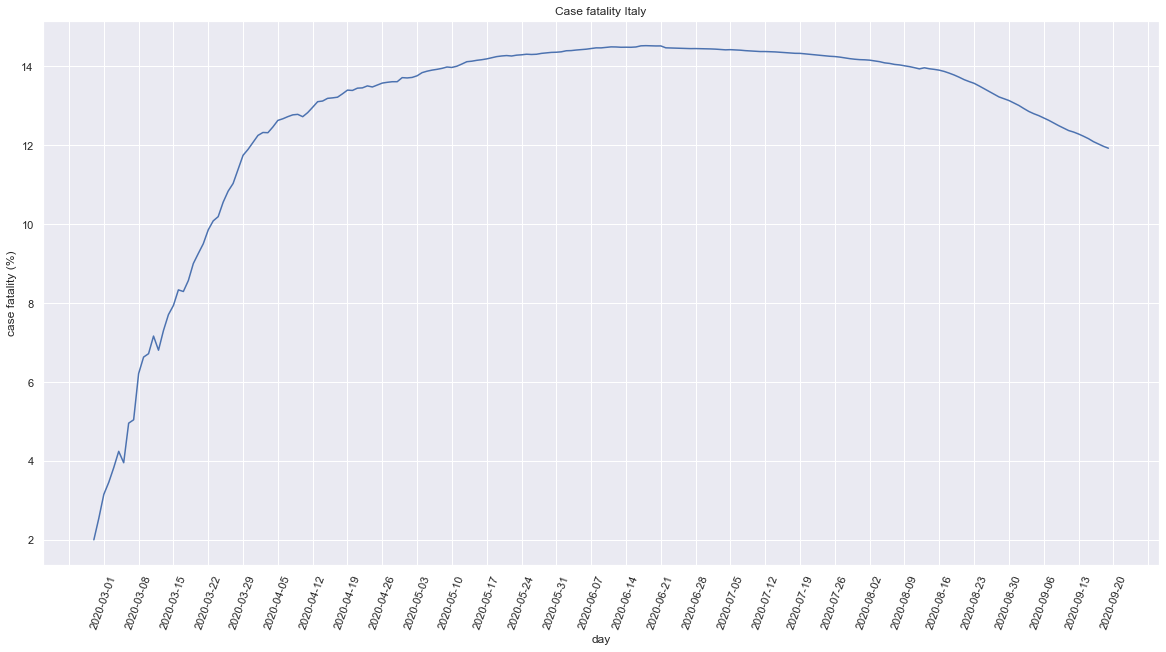

In [306]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Italy")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.plot(cf_it['2020-02-22':])

***
## Germany

In [307]:
population_de = population[population['country_code'] == 'DE']['total'].values[0]
print("Germany's population (2019) = %d"%population_de)

Germany's population (2019) = 83019213


In [308]:
beds_de = beds[beds['country_code'] == 'DE']['2017'].values[0]
print("Germany's public and private health care facilities, available beds in 2017 = %d"%beds_de)

Germany's public and private health care facilities, available beds in 2017 = 661448


In [309]:
people_per_bed_de =  population_de / beds_de 
print("Number of persons per bed = %.0f"%people_per_bed_de)

Number of persons per bed = 126


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [310]:
confirmed_dataset_de = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Germany'] 
confirmed_dataset_values_de = [confirmed for confirmed in confirmed_dataset_de.values[0][start_date_index:]] 
confirmed_infections_de = pd.Series(confirmed_dataset_values_de, index=dates_index)
confirmed_infections_de['2020-09-01':] 

2020-09-01    246015
2020-09-02    247411
2020-09-03    248840
2020-09-04    250283
2020-09-05    251058
2020-09-06    251728
2020-09-07    253626
2020-09-08    254957
2020-09-09    256433
2020-09-10    258149
2020-09-11    259735
2020-09-12    260817
2020-09-13    261737
2020-09-14    263222
2020-09-15    265014
2020-09-16    266869
2020-09-17    269048
2020-09-18    271247
2020-09-19    272932
2020-09-20    273965
2020-09-21    275560
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [311]:
confirmed_per_day_array_de = [confirmed_infections_de[d++1] - confirmed_infections_de[d] for d in range(dates_index.size - 1)]
confirmed_per_day_de = pd.Series(confirmed_per_day_array_de, index=dates_index[1:])
confirmed_per_day_de['2020-09-01':]

2020-09-01    1213
2020-09-02    1396
2020-09-03    1429
2020-09-04    1443
2020-09-05     775
2020-09-06     670
2020-09-07    1898
2020-09-08    1331
2020-09-09    1476
2020-09-10    1716
2020-09-11    1586
2020-09-12    1082
2020-09-13     920
2020-09-14    1485
2020-09-15    1792
2020-09-16    1855
2020-09-17    2179
2020-09-18    2199
2020-09-19    1685
2020-09-20    1033
2020-09-21    1595
dtype: int64

<BarContainer object of 204 artists>

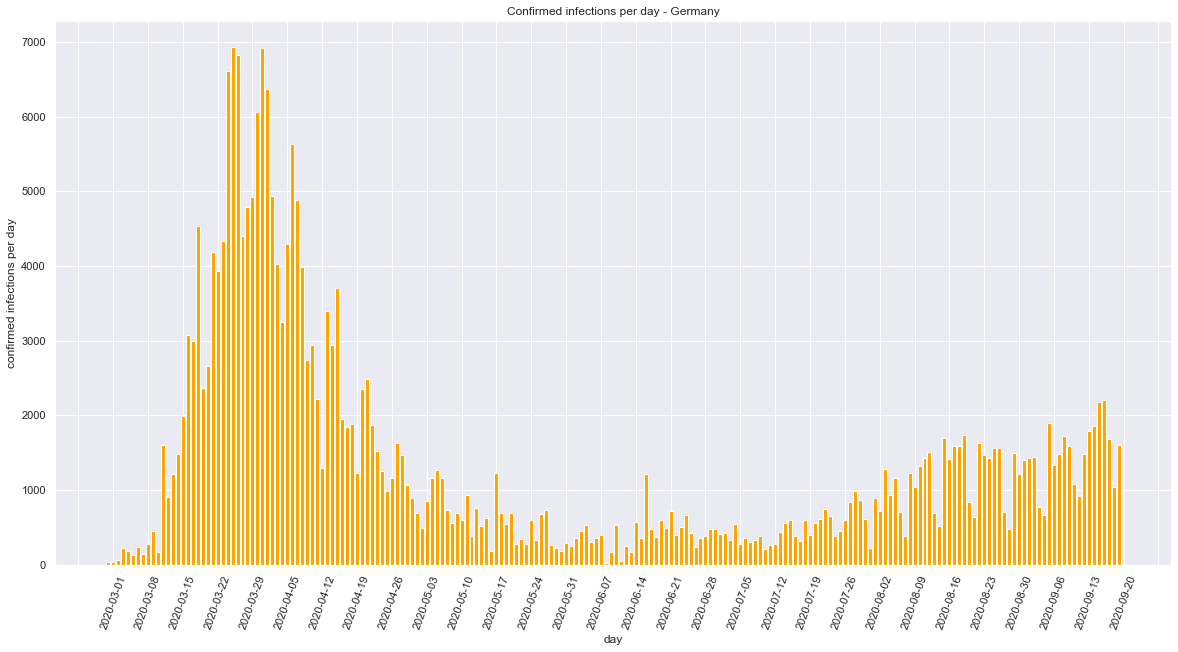

In [312]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], confirmed_per_day_array_de, color='orange')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [313]:
deaths_dataset_de = deaths_dataset[deaths_dataset['Country/Region'] == 'Germany']
deaths_dataset_values_de = [death for death in deaths_dataset_de.values[0][start_date_index:]]
deaths_de = pd.Series(deaths_dataset_values_de, index=dates_index)
deaths_de['2020-09-01':]

2020-09-01    9307
2020-09-02    9322
2020-09-03    9322
2020-09-04    9327
2020-09-05    9329
2020-09-06    9330
2020-09-07    9331
2020-09-08    9336
2020-09-09    9342
2020-09-10    9345
2020-09-11    9348
2020-09-12    9352
2020-09-13    9354
2020-09-14    9356
2020-09-15    9367
2020-09-16    9373
2020-09-17    9376
2020-09-18    9386
2020-09-19    9388
2020-09-20    9390
2020-09-21    9390
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [314]:
deaths_per_day_array_de = [deaths_de[d++1] - deaths_de[d] for d in range(dates_index.size - 1)]
deaths_per_day_de = pd.Series(deaths_per_day_array_de, index=dates_index[1:])
deaths_per_day_de['2020-09-01':]

2020-09-01     4
2020-09-02    15
2020-09-03     0
2020-09-04     5
2020-09-05     2
2020-09-06     1
2020-09-07     1
2020-09-08     5
2020-09-09     6
2020-09-10     3
2020-09-11     3
2020-09-12     4
2020-09-13     2
2020-09-14     2
2020-09-15    11
2020-09-16     6
2020-09-17     3
2020-09-18    10
2020-09-19     2
2020-09-20     2
2020-09-21     0
dtype: int64

<BarContainer object of 204 artists>

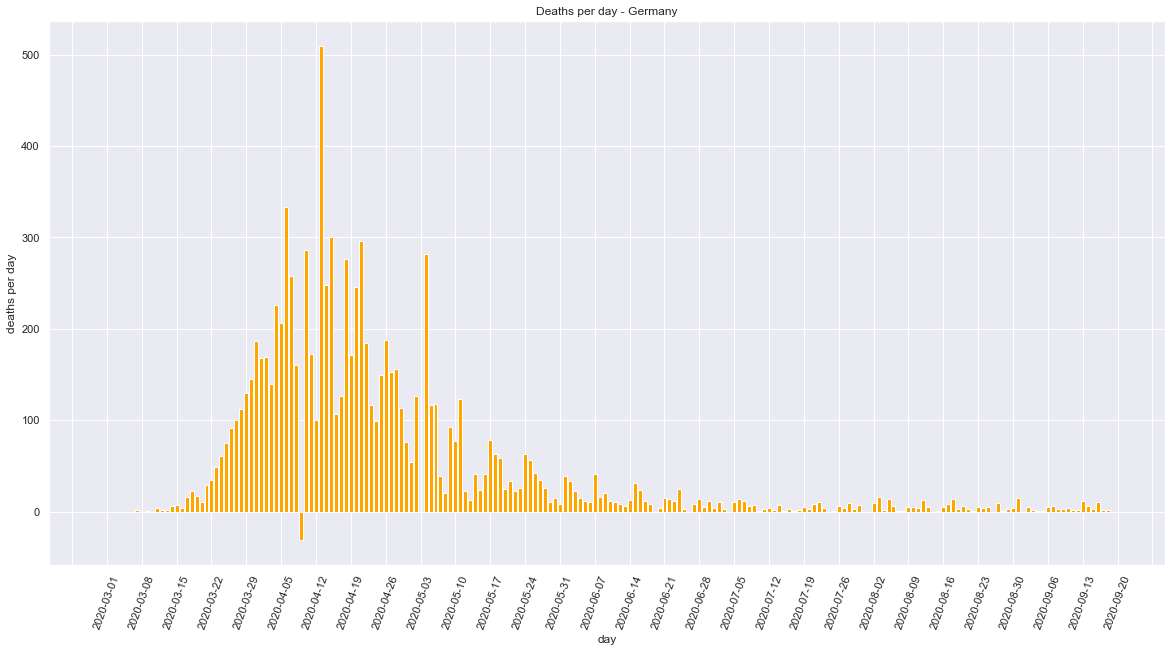

In [315]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Germany")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], deaths_per_day_array_de, color='orange')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [316]:
doubling_time_de = doubling_time(confirmed_infections_de)[last_day]
summary['Doubling Time']['Germany'] = doubling_time(confirmed_infections_de)[last_day]
print("Germany's cumulative infections doubling time = %.0d days"%doubling_time_de)

Germany's cumulative infections doubling time = 158 days


### Cumulative incidence

In [317]:
cumulative_incidence_de = (confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000
summary['Incidence']['Germany'] = round((confirmed_infections_de[confirmed_infections_de.size - 1] / population_de) * 100000)
print("Germany's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_de)

Germany's cumulative incidence = 332 per 100.000 persons


### Case fatality

In [318]:
last_infections_de = confirmed_infections_de[confirmed_infections_de.size - 1]
last_deaths_de = deaths_de[deaths_de.size - 1]
last_case_fatality_de = (last_deaths_de / last_infections_de) * 100 
summary['Confirmed Infections']['Germany'] = confirmed_infections_de[confirmed_infections_de.size - 1]
summary['Deaths']['Germany'] = deaths_de[deaths_de.size - 1]
summary['Case Fatality']['Germany'] = round((deaths_de[deaths_de.size - 1] / confirmed_infections_de[confirmed_infections_de.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_de, last_infections_de, last_case_fatality_de))  

Last report day: 2020-09-21 
deaths:  9390; cumulative confirmed infections: 275560; case fatality  3.41 %


In [319]:
cf_array_de = [(deaths_de[d] / confirmed_infections_de[d]) * 100 for d in range(dates_index.size)]
cf_de = pd.Series(cf_array_de, index=dates_index)

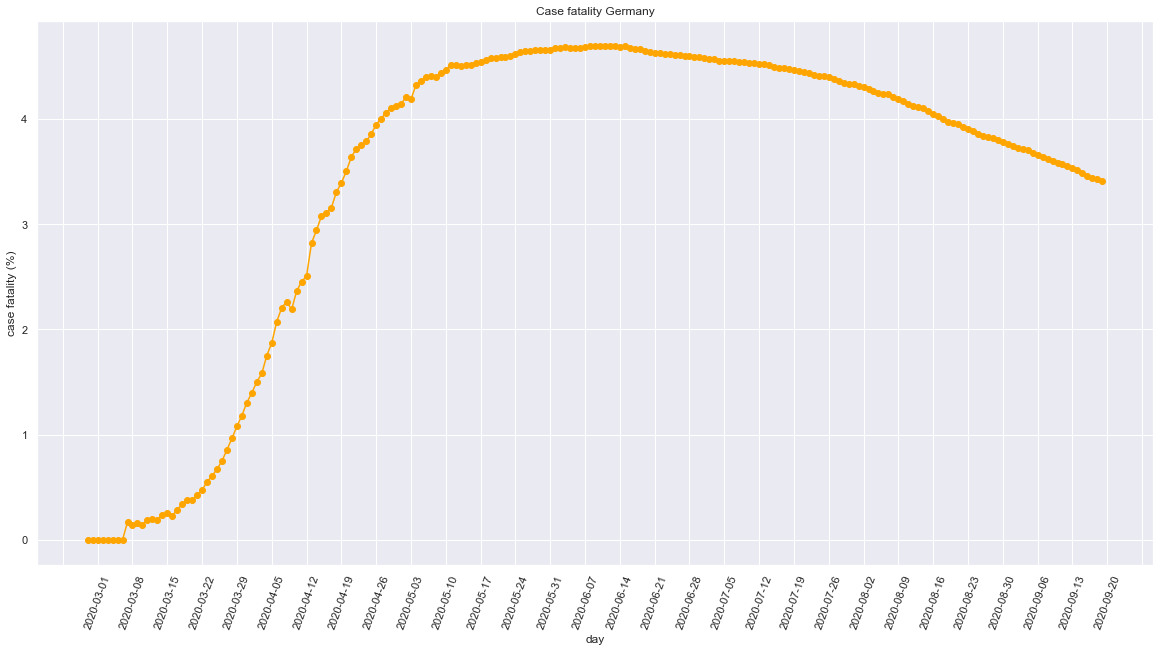

In [320]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Germany")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.plot(cf_de['2020-02-22':], color='orange', marker='o')

***
## France

In [321]:
population_fr = population[population['country_code'] == 'FR']['total'].values[0]
print("France's population (2019) = %d"%population_fr)

France's population (2019) = 67012883


In [322]:
beds_fr = beds[beds['country_code'] == 'FR']['2017'].values[0]
print("France's public and private health care facilities, available beds in 2017 = %d"%beds_fr)

France's public and private health care facilities, available beds in 2017 = 399865


In [323]:
people_per_bed_fr =  population_fr / beds_fr 
print("Number of persons per bed = %.0f"%people_per_bed_fr)

Number of persons per bed = 168


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [324]:
confirmed_dataset_fr = confirmed_dataset[confirmed_dataset['Country/Region'] == 'France']
row_france = 10
confirmed_dataset_values_fr = [confirmed for confirmed in confirmed_dataset_fr.values[row_france][start_date_index:]] 
confirmed_infections_fr = pd.Series(confirmed_dataset_values_fr, index=dates_index)
confirmed_infections_fr['2020-09-01':] 

2020-09-01    306951
2020-09-02    313730
2020-09-03    320656
2020-09-04    329512
2020-09-05    329353
2020-09-06    329246
2020-09-07    348982
2020-09-08    355244
2020-09-09    363751
2020-09-10    372501
2020-09-11    381907
2020-09-12    381907
2020-09-13    381907
2020-09-14    404564
2020-09-15    412360
2020-09-16    421861
2020-09-17    431966
2020-09-18    444978
2020-09-19    444978
2020-09-20    444978
2020-09-21    473974
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [325]:
confirmed_per_day_array_fr = [confirmed_infections_fr[d++1] - confirmed_infections_fr[d] for d in range(dates_index.size - 1)]
confirmed_per_day_fr = pd.Series(confirmed_per_day_array_fr, index=dates_index[1:])
confirmed_per_day_fr['2020-09-01':]

2020-09-01     4776
2020-09-02     6779
2020-09-03     6926
2020-09-04     8856
2020-09-05     -159
2020-09-06     -107
2020-09-07    19736
2020-09-08     6262
2020-09-09     8507
2020-09-10     8750
2020-09-11     9406
2020-09-12        0
2020-09-13        0
2020-09-14    22657
2020-09-15     7796
2020-09-16     9501
2020-09-17    10105
2020-09-18    13012
2020-09-19        0
2020-09-20        0
2020-09-21    28996
dtype: int64

<BarContainer object of 204 artists>

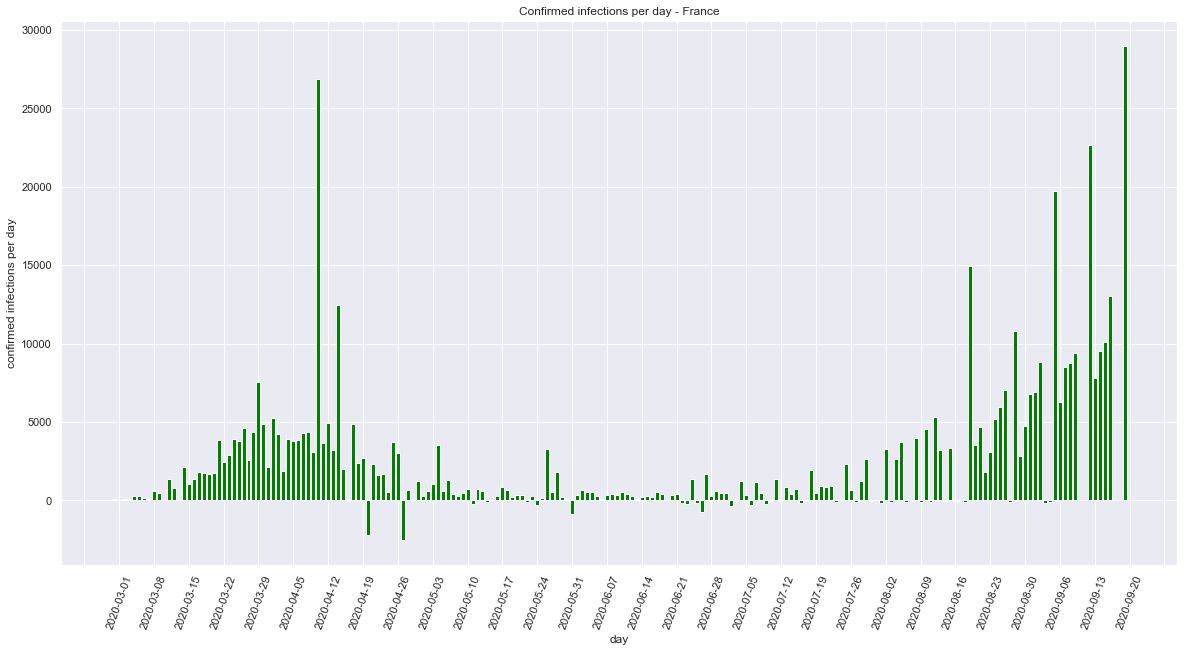

In [326]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - France")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], confirmed_per_day_array_fr, color='green')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [327]:
deaths_dataset_fr = deaths_dataset[deaths_dataset['Country/Region'] == 'France']
deaths_dataset_values_fr = [death for death in deaths_dataset_fr.values[row_france][start_date_index:]]
deaths_fr = pd.Series(deaths_dataset_values_fr, index=dates_index)
deaths_fr['2020-09-01':]

2020-09-01    30518
2020-09-02    30539
2020-09-03    30559
2020-09-04    30576
2020-09-05    30575
2020-09-06    30573
2020-09-07    30575
2020-09-08    30613
2020-09-09    30643
2020-09-10    30656
2020-09-11    30735
2020-09-12    30735
2020-09-13    30735
2020-09-14    30790
2020-09-15    30838
2020-09-16    30884
2020-09-17    30931
2020-09-18    31085
2020-09-19    31085
2020-09-20    31085
2020-09-21    31174
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [328]:
deaths_per_day_array_fr = [deaths_fr[d++1] - deaths_fr[d] for d in range(dates_index.size - 1)]
deaths_per_day_fr = pd.Series(deaths_per_day_array_fr, index=dates_index[1:])
deaths_per_day_fr['2020-09-01':]

2020-09-01     23
2020-09-02     21
2020-09-03     20
2020-09-04     17
2020-09-05     -1
2020-09-06     -2
2020-09-07      2
2020-09-08     38
2020-09-09     30
2020-09-10     13
2020-09-11     79
2020-09-12      0
2020-09-13      0
2020-09-14     55
2020-09-15     48
2020-09-16     46
2020-09-17     47
2020-09-18    154
2020-09-19      0
2020-09-20      0
2020-09-21     89
dtype: int64

<BarContainer object of 204 artists>

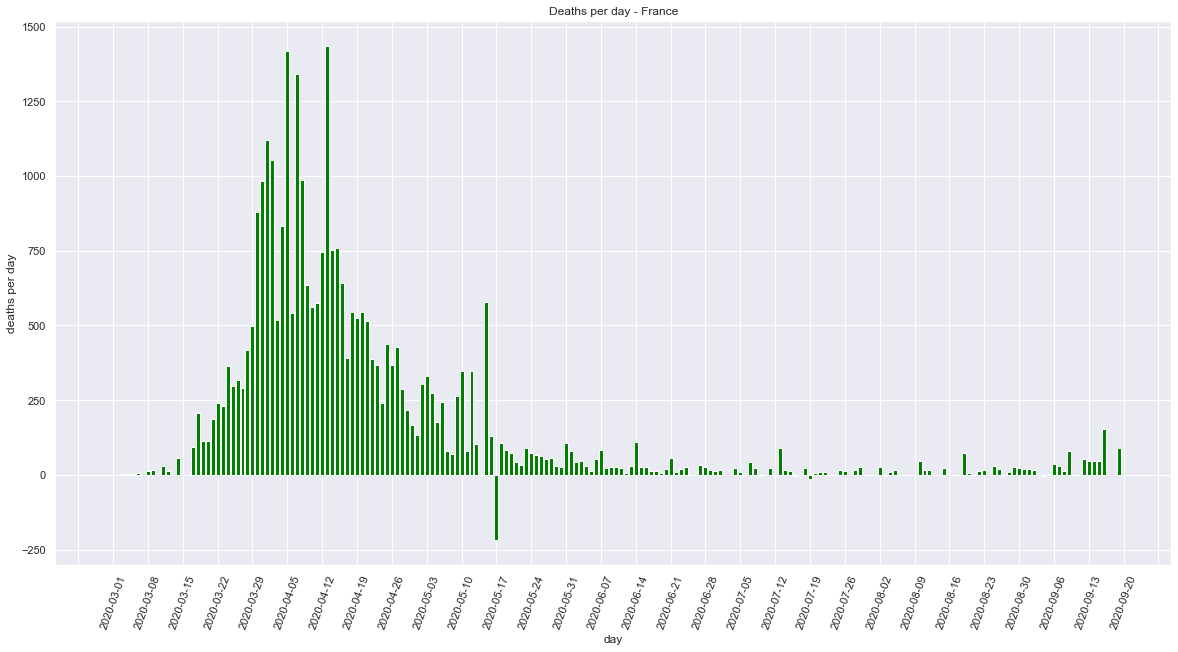

In [329]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - France")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], deaths_per_day_array_fr, color='green')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [330]:
doubling_time_fr = doubling_time(confirmed_infections_fr)[last_day]
summary['Doubling Time']['France'] = doubling_time(confirmed_infections_fr)[last_day]
print("France's cumulative infections doubling time = %.0d days"%doubling_time_fr)

France's cumulative infections doubling time = 38 days


### Cumulative incidence

In [331]:
cumulative_incidence_fr = (confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000
summary['Incidence']['France'] = round((confirmed_infections_fr[confirmed_infections_fr.size - 1] / population_fr) * 100000)
print("France's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_fr)

France's cumulative incidence = 707 per 100.000 persons


### Case fatality

In [332]:
last_infections_fr = confirmed_infections_fr[confirmed_infections_fr.size - 1]
last_deaths_fr = deaths_fr[deaths_fr.size - 1]
last_case_fatality_fr = (last_deaths_fr / last_infections_fr) * 100 
summary['Confirmed Infections']['France'] = confirmed_infections_fr[confirmed_infections_fr.size - 1]
summary['Deaths']['France'] = deaths_fr[deaths_fr.size - 1]
summary['Case Fatality']['France'] = round((deaths_fr[deaths_fr.size - 1] / confirmed_infections_fr[confirmed_infections_fr.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_fr, last_infections_fr, last_case_fatality_fr))  

Last report day: 2020-09-21 
deaths: 31174; cumulative confirmed infections: 473974; case fatality  6.58 %


In [333]:
cf_array_fr = [(deaths_fr[d] / confirmed_infections_fr[d]) * 100 for d in range(dates_index.size)]
cf_fr = pd.Series(cf_array_fr, index=dates_index)

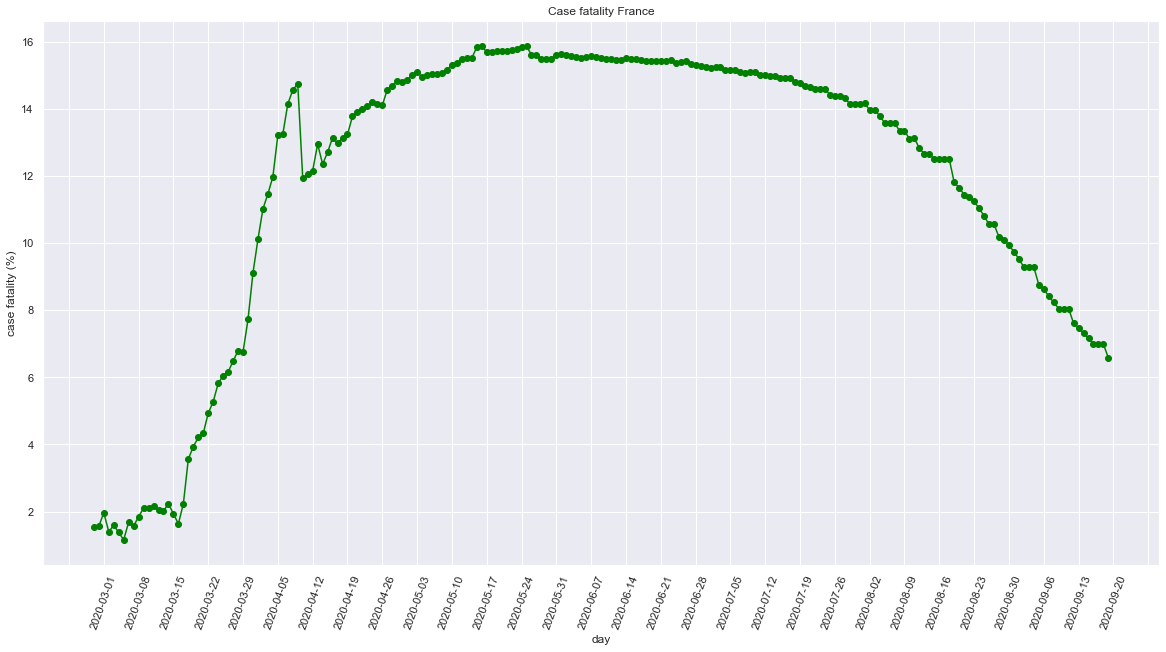

In [334]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality France")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.plot(cf_fr['2020-02-22':], color='green', marker='o')

***
## Spain

In [335]:
population_es = population[population['country_code'] == 'ES']['total'].values[0]
print("Spain's population (2019) = %d"%population_es)

Spain's population (2019) = 46937060


In [336]:
beds_es = beds[beds['country_code'] == 'ES']['2017'].values[0]
print("Spain's public and private health care facilities, available beds in 2017 = %d"%beds_es)

Spain's public and private health care facilities, available beds in 2017 = 138511


In [337]:
people_per_bed_es =  population_es / beds_es 
print("Number of persons per bed = %.0f"%people_per_bed_es)

Number of persons per bed = 339


### Cumulative confirmed infections
The number of infected individuals each day is the sum of all the confirmed infected individuals from the beginning up to that day.

In [338]:
confirmed_dataset_es = confirmed_dataset[confirmed_dataset['Country/Region'] == 'Spain'] 
confirmed_dataset_values_es = [confirmed for confirmed in confirmed_dataset_es.values[0][start_date_index:]] 
confirmed_infections_es = pd.Series(confirmed_dataset_values_es, index=dates_index)
confirmed_infections_es['2020-09-01':] 

2020-09-01    470973
2020-09-02    479554
2020-09-03    488513
2020-09-04    498989
2020-09-05    498989
2020-09-06    498989
2020-09-07    525549
2020-09-08    534513
2020-09-09    543379
2020-09-10    554143
2020-09-11    566326
2020-09-12    566326
2020-09-13    566326
2020-09-14    593730
2020-09-15    603167
2020-09-16    614360
2020-09-17    625651
2020-09-18    640040
2020-09-19    640040
2020-09-20    640040
2020-09-21    671468
dtype: int64

### Confirmed infections per day
The confirmed infections per day are computed from the cumulative confirmed infections by computing the difference between two consecutive days.

In [339]:
confirmed_per_day_array_es = [confirmed_infections_es[d++1] - confirmed_infections_es[d] for d in range(dates_index.size - 1)]
confirmed_per_day_es = pd.Series(confirmed_per_day_array_es, index=dates_index[1:])
confirmed_per_day_es['2020-09-01':]

2020-09-01     8115
2020-09-02     8581
2020-09-03     8959
2020-09-04    10476
2020-09-05        0
2020-09-06        0
2020-09-07    26560
2020-09-08     8964
2020-09-09     8866
2020-09-10    10764
2020-09-11    12183
2020-09-12        0
2020-09-13        0
2020-09-14    27404
2020-09-15     9437
2020-09-16    11193
2020-09-17    11291
2020-09-18    14389
2020-09-19        0
2020-09-20        0
2020-09-21    31428
dtype: int64

<BarContainer object of 204 artists>

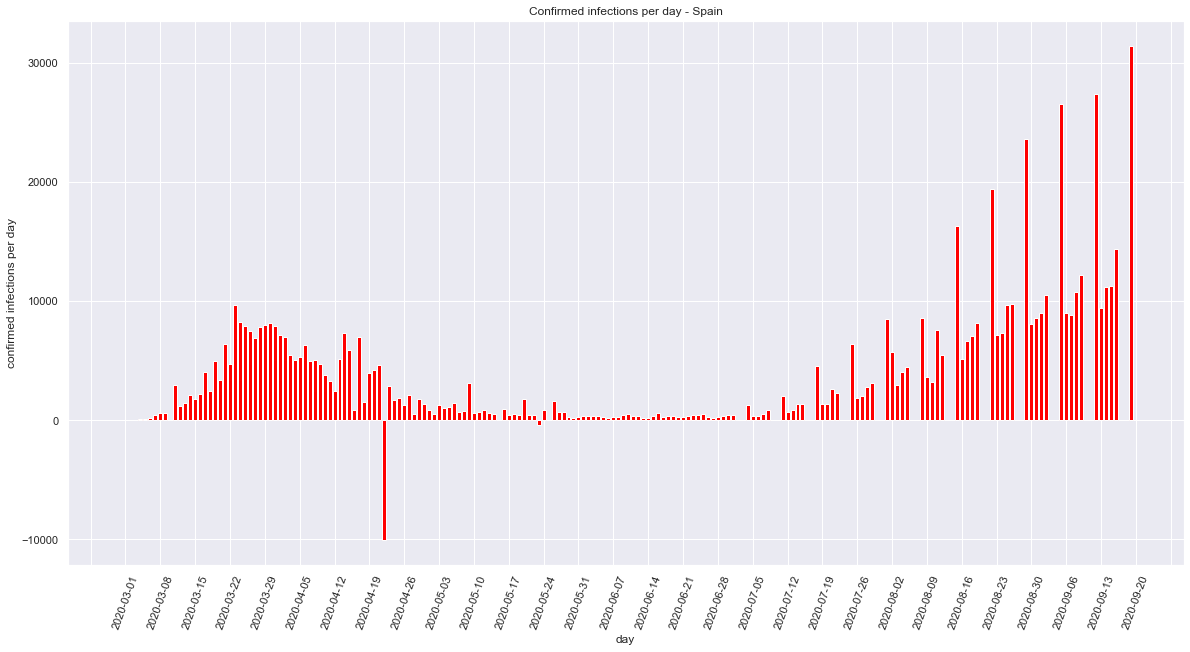

In [340]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], confirmed_per_day_array_es, color='red')

### Cumulative deaths
The number of deaths each day is the sum of the deaths from the beginning up to that day.

In [341]:
deaths_dataset_es = deaths_dataset[deaths_dataset['Country/Region'] == 'Spain']
deaths_dataset_values_es = [death for death in deaths_dataset_es.values[0][start_date_index:]]
deaths_es = pd.Series(deaths_dataset_values_es, index=dates_index)
deaths_es['2020-09-01':]

2020-09-01    29152
2020-09-02    29194
2020-09-03    29234
2020-09-04    29418
2020-09-05    29418
2020-09-06    29418
2020-09-07    29516
2020-09-08    29594
2020-09-09    29628
2020-09-10    29699
2020-09-11    29747
2020-09-12    29747
2020-09-13    29747
2020-09-14    29848
2020-09-15    30004
2020-09-16    30243
2020-09-17    30405
2020-09-18    30495
2020-09-19    30495
2020-09-20    30495
2020-09-21    30663
dtype: int64

### Deaths per day
The deaths per day are computed from the cumulative deaths by computing the difference between two consecutive days.

In [342]:
deaths_per_day_array_es = [deaths_es[d++1] - deaths_es[d] for d in range(dates_index.size - 1)]
deaths_per_day_es = pd.Series(deaths_per_day_array_es, index=dates_index[1:])
deaths_per_day_es['2020-09-01':]

2020-09-01     58
2020-09-02     42
2020-09-03     40
2020-09-04    184
2020-09-05      0
2020-09-06      0
2020-09-07     98
2020-09-08     78
2020-09-09     34
2020-09-10     71
2020-09-11     48
2020-09-12      0
2020-09-13      0
2020-09-14    101
2020-09-15    156
2020-09-16    239
2020-09-17    162
2020-09-18     90
2020-09-19      0
2020-09-20      0
2020-09-21    168
dtype: int64

<BarContainer object of 204 artists>

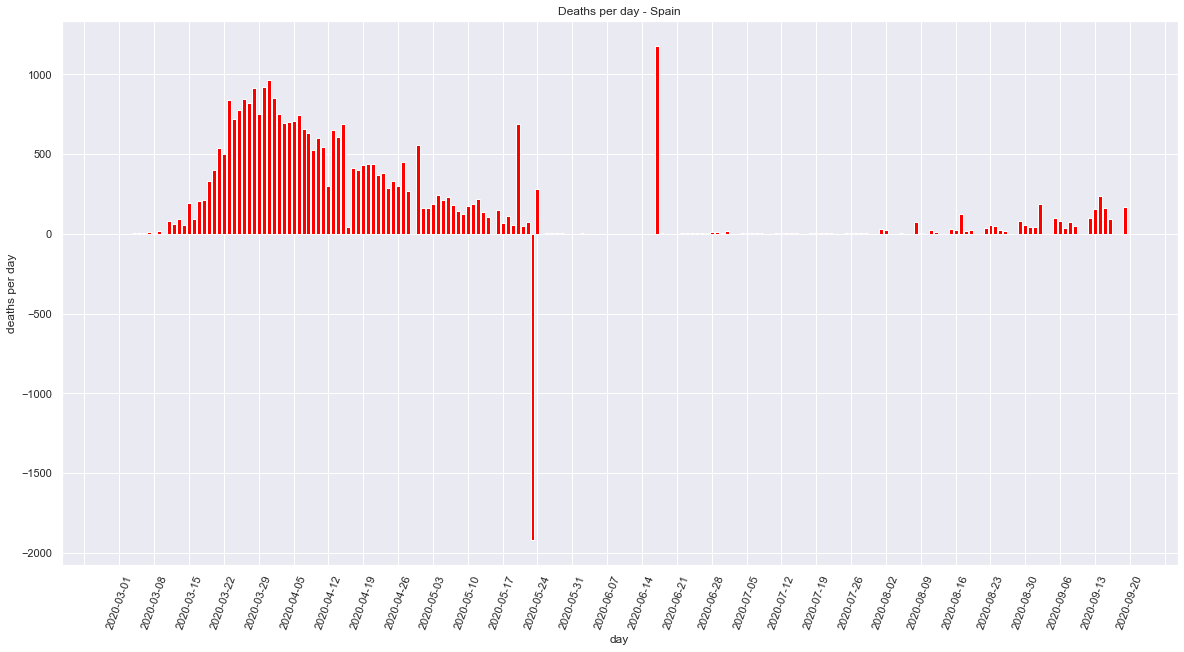

In [343]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Spain")
ax.set_xlabel("day")
ax.set_ylabel("deaths per day");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.bar(dates_array[1:], deaths_per_day_array_es, color='red')

### Cumulative confirmed infections doubling time
Number of days for the cumulative confirmed infections to double

In [344]:
doubling_time_es = doubling_time(confirmed_infections_es)[last_day]
summary['Doubling Time']['Spain'] = doubling_time(confirmed_infections_es)[last_day]
print("Spain's cumulative infections doubling time = %.0d days"%doubling_time_es)

Spain's cumulative infections doubling time = 40 days


### Cumulative incidence

In [345]:
cumulative_incidence_es = (confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000
summary['Incidence']['Spain'] = round((confirmed_infections_es[confirmed_infections_es.size - 1] / population_es) * 100000)
print("Spain's cumulative incidence = %.0f per 100.000 persons"%cumulative_incidence_es)

Spain's cumulative incidence = 1431 per 100.000 persons


### Case fatality

In [346]:
last_infections_es = confirmed_infections_es[confirmed_infections_es.size - 1]
last_deaths_es = deaths_es[deaths_es.size - 1]
last_case_fatality_es = (last_deaths_es / last_infections_es) * 100 
summary['Confirmed Infections']['Spain'] = confirmed_infections_es[confirmed_infections_es.size - 1]
summary['Deaths']['Spain'] = deaths_es[deaths_es.size - 1]
summary['Case Fatality']['Spain'] = round((deaths_es[deaths_es.size - 1] / confirmed_infections_es[confirmed_infections_es.size - 1]) * 100,1)
print("Last report day: {0:4s} \ndeaths: {1:5d}; cumulative confirmed infections: {2:5d}; case fatality {3:5.2f} %".format(last_day, last_deaths_es, last_infections_es, last_case_fatality_es))  

Last report day: 2020-09-21 
deaths: 30663; cumulative confirmed infections: 671468; case fatality  4.57 %


In [347]:
cf_array_es = [(deaths_es[d] / confirmed_infections_es[d]) * 100 for d in range(dates_index.size)]
cf_es = pd.Series(cf_array_es, index=dates_index)

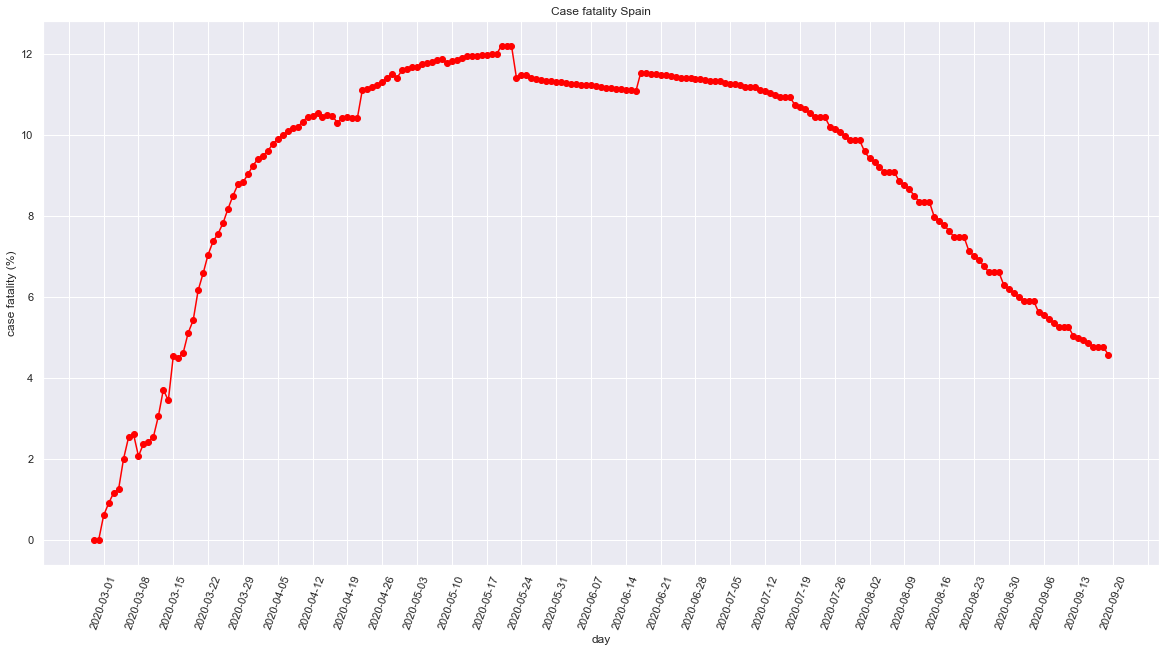

In [348]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Spain")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.plot(cf_es['2020-02-22':], color='red', marker='o')

***
## Comparisons
Merged graphs for Italy, Germany, France and Spain

### Cumulative confirmed infections

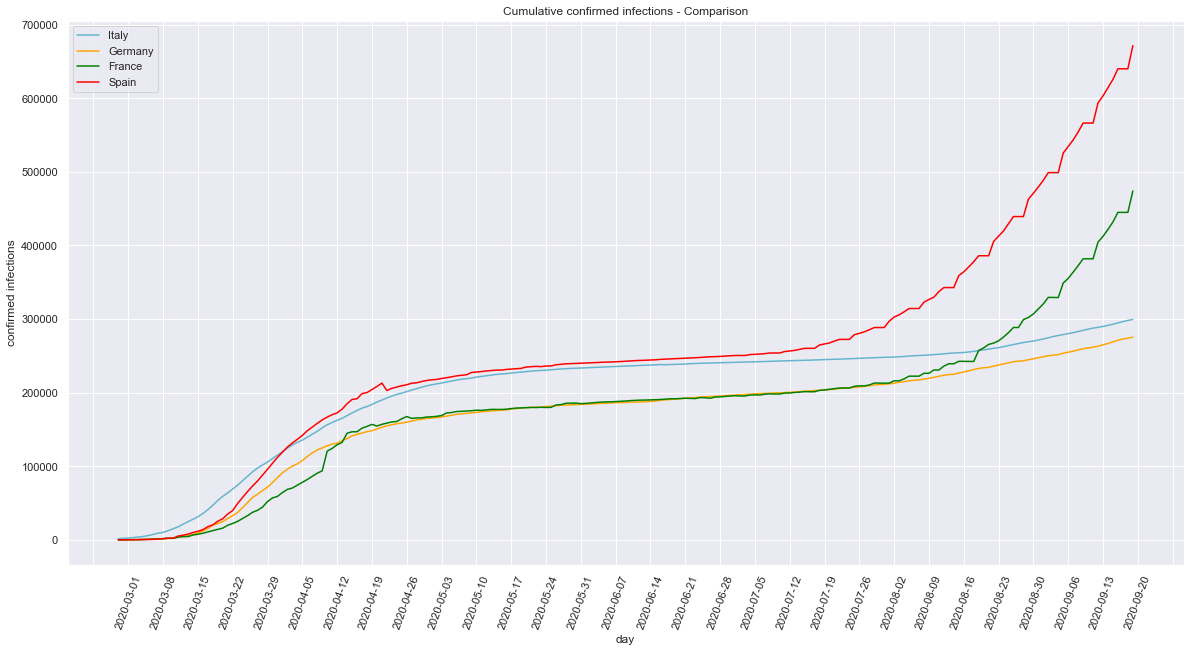

In [349]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative confirmed infections - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("confirmed infections");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pi_it, = plt.plot(confirmed_infections_it['2020-02-24':], label='Italy', color='c')
pi_de, = plt.plot(confirmed_infections_de['2020-02-24':], label='Germany', color='orange')
pi_fr, = plt.plot(confirmed_infections_fr['2020-02-24':], label='France', color='green')
pi_es, = plt.plot(confirmed_infections_es['2020-02-24':], label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])

### Doubling Time
Doubling time for the confirmed infections

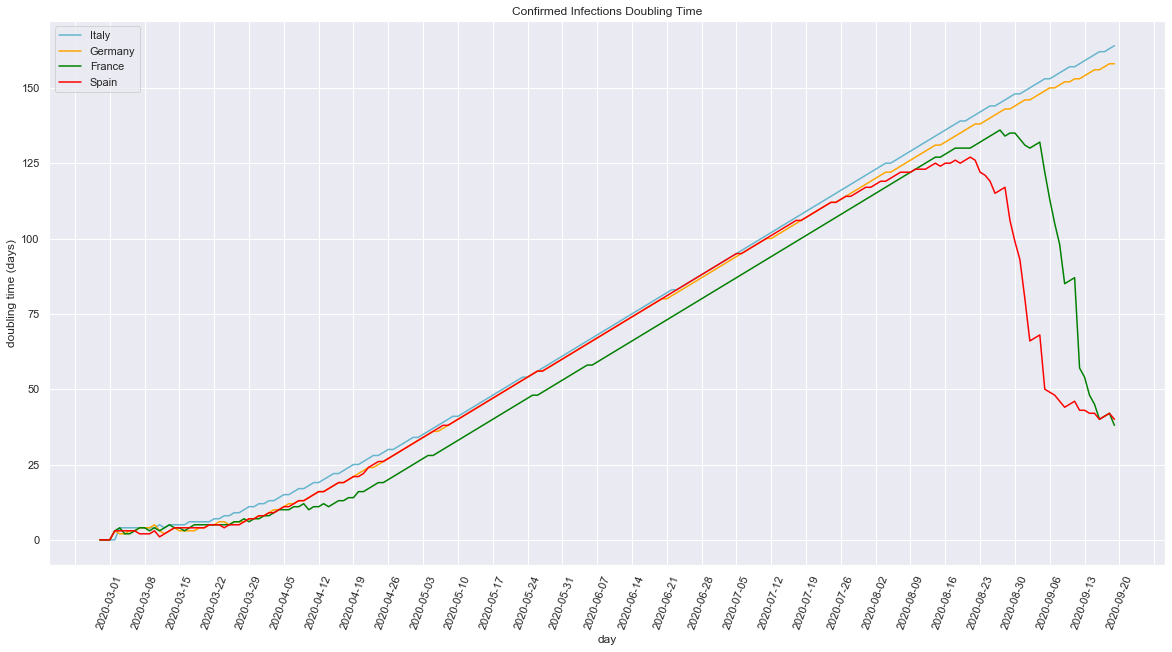

In [350]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed Infections Doubling Time")
ax.set_xlabel("day")
ax.set_ylabel("doubling time (days)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pi_it, = plt.plot(doubling_time(confirmed_infections_it)['2020-03-01':], label='Italy', color='c')
pi_de, = plt.plot(doubling_time(confirmed_infections_de)['2020-03-01':], label='Germany', color='orange')
pi_fr, = plt.plot(doubling_time(confirmed_infections_fr)['2020-03-01':], label='France', color='green')
pi_es, = plt.plot(doubling_time(confirmed_infections_es)['2020-03-01':], label='Spain', color='red')
plt.legend(handles=[pi_it, pi_de, pi_fr, pi_es])
#plt.savefig('doubling-time.png')

### Cumulative deaths

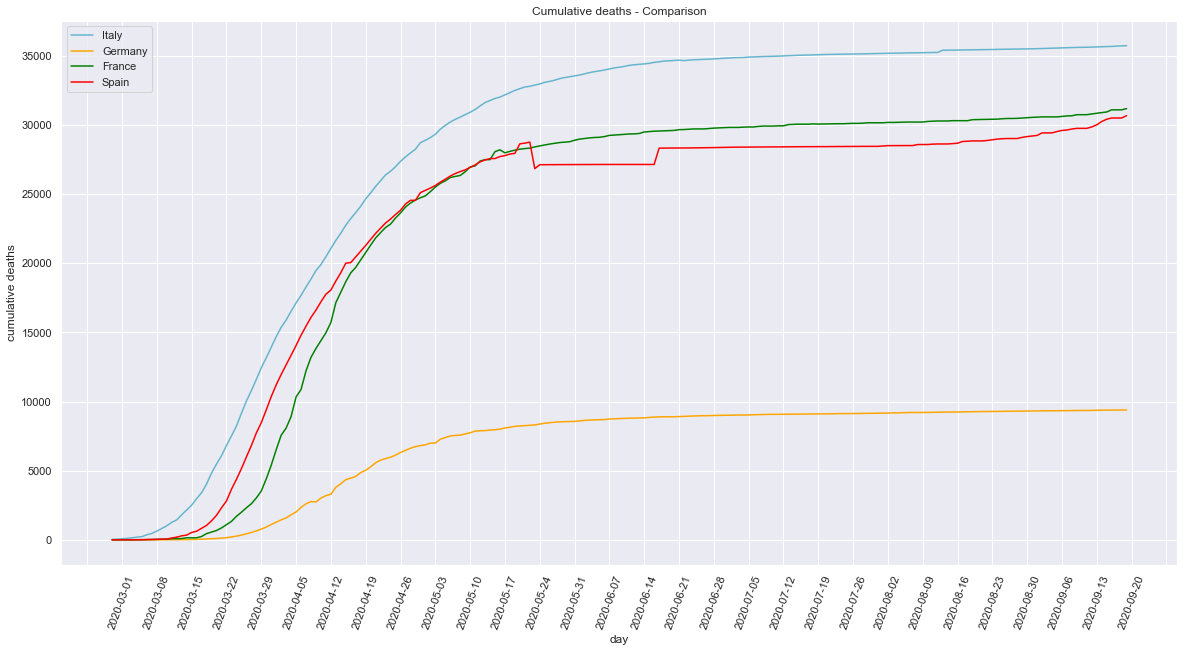

In [351]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Cumulative deaths - Comparison")
ax.set_xlabel("day")
ax.set_ylabel("cumulative deaths");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pd_it, = plt.plot(deaths_it['2020-03-01':], label='Italy', color='c')
pd_de, = plt.plot(deaths_de['2020-03-01':], label='Germany', color='orange')
pd_fr, = plt.plot(deaths_fr['2020-03-01':], label='France', color='green')
pd_es, = plt.plot(deaths_es['2020-03-01':], label='Spain', color='red')
plt.legend(handles=[pd_it, pd_de, pd_fr, pd_es])

### Confirmed infections per day

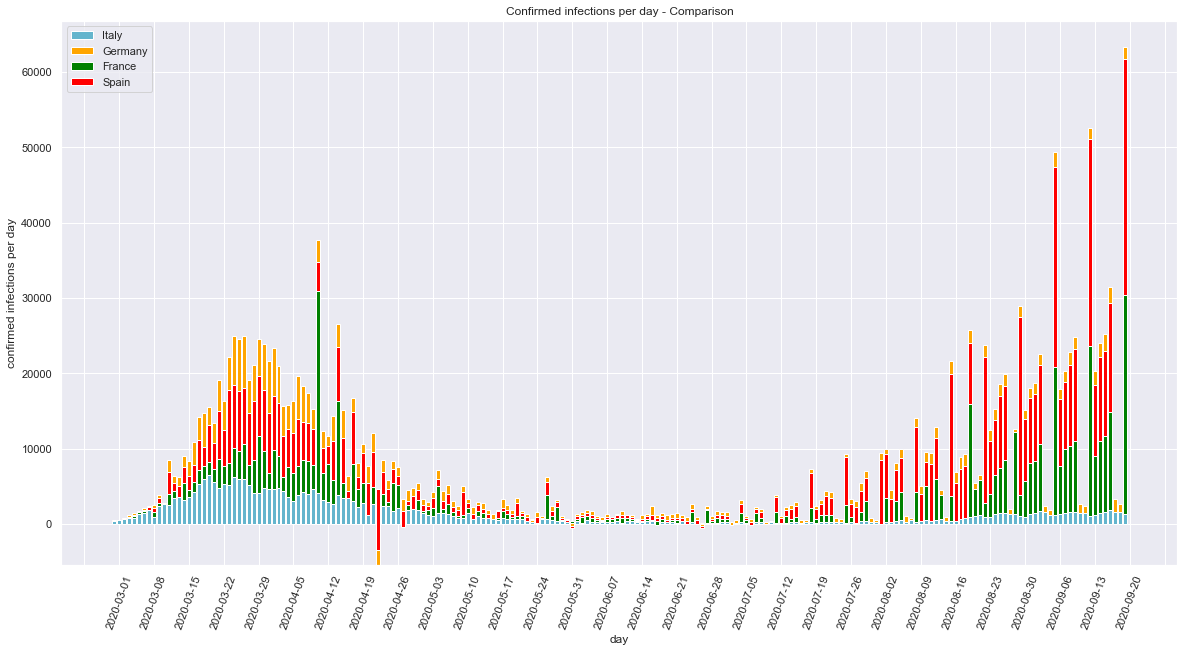

In [352]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Confirmed infections per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('confirmed infections per day')
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pi_it = plt.bar(dates_array[1:], confirmed_per_day_array_it, color='c')
pi_fr = plt.bar(dates_array[1:], confirmed_per_day_array_fr, bottom=confirmed_per_day_array_it, color='green')
len_array = len(confirmed_per_day_array_it)
bar_base = [confirmed_per_day_array_it[d] + confirmed_per_day_array_fr[d] for d in range(len_array)]
pi_es = plt.bar(dates_array[1:], confirmed_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + confirmed_per_day_array_es[d] for d in range(len_array)] # bottom update
pi_de = plt.bar(dates_array[1:], confirmed_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi_it, pi_de, pi_fr, pi_es), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Deaths per day

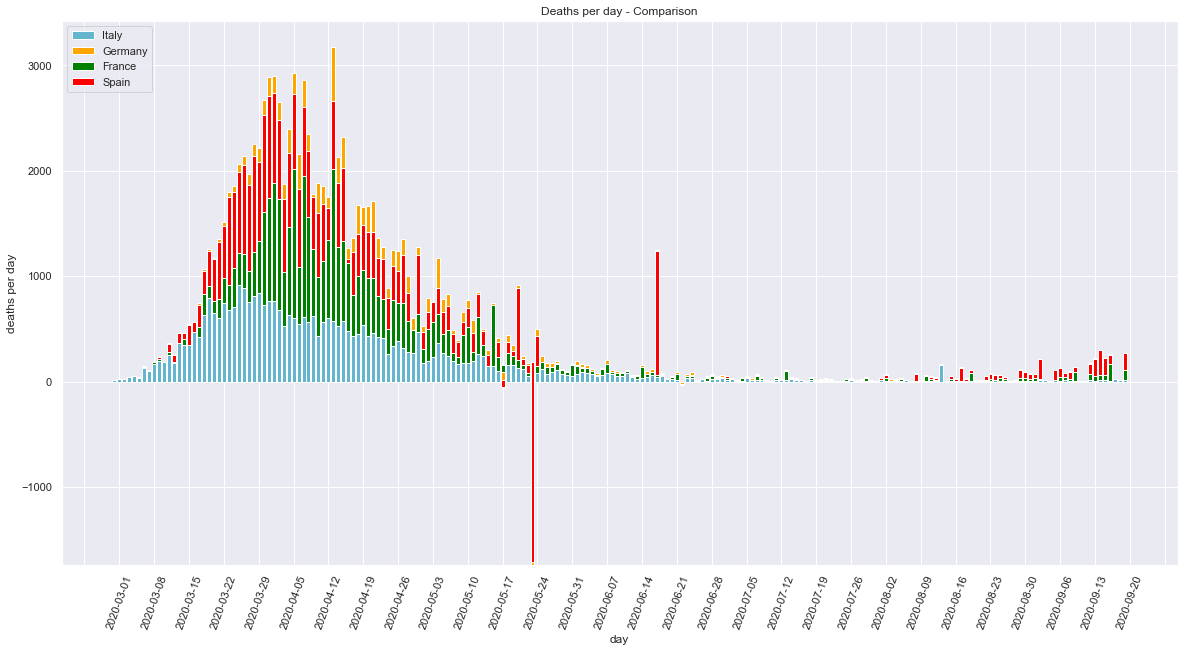

In [353]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Deaths per day - Comparison")
ax.set_xlabel("day")
ax.set_ylabel('deaths per day')
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pi = plt.bar(dates_array[1:], deaths_per_day_array_it, color='c')
pf = plt.bar(dates_array[1:], deaths_per_day_array_fr, bottom = deaths_per_day_array_it, color='green')
len_array = len(deaths_per_day_array_it)
bar_base = [deaths_per_day_array_it[d] + deaths_per_day_array_fr[d] for d in range(len_array)]
ps = plt.bar(dates_array[1:], deaths_per_day_array_es, bottom = bar_base, color='red')
bar_base = [bar_base[d] + deaths_per_day_array_es[d] for d in range(len_array)]
pg = plt.bar(dates_array[1:], deaths_per_day_array_de, bottom = bar_base, color='orange')
plt.legend((pi[0], pg[0], pf[0], ps[0]), ['Italy', 'Germany', 'France', 'Spain'], loc='upper left')
#plt.savefig('deaths-per-day.png')

### Case fatality

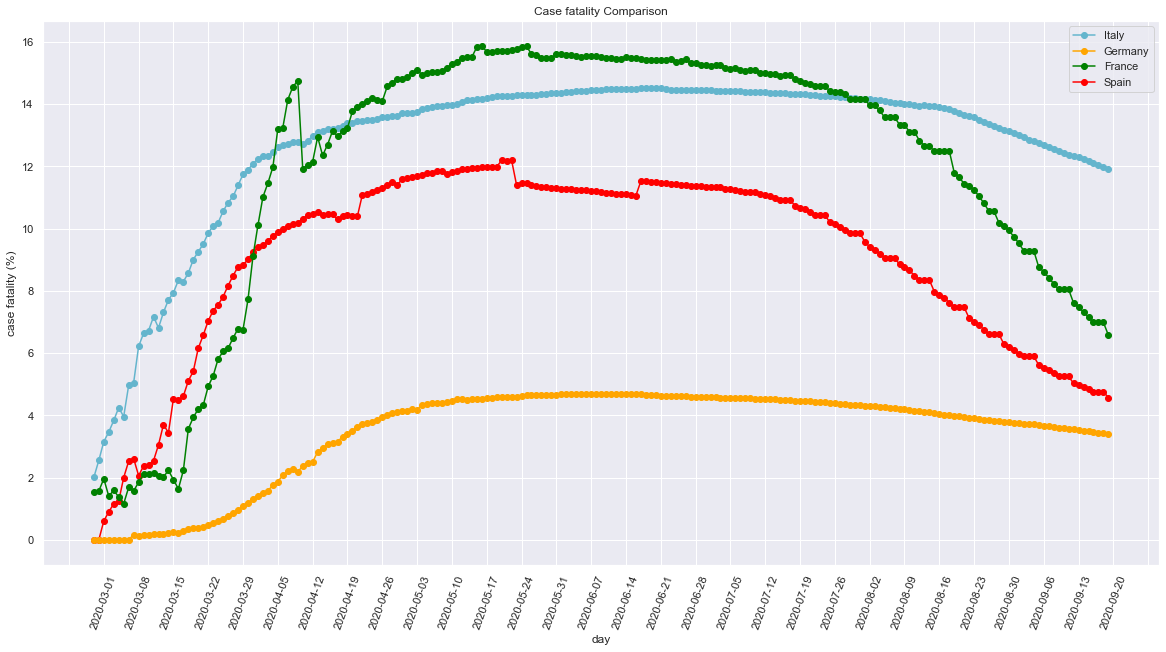

In [354]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()
ax.set_title("Case fatality Comparison")
ax.set_xlabel("day")
ax.set_ylabel("case fatality (%)");
ax.set_xticks(week_days)
ax.set_xticklabels(week_days.format('%Y-%m-%d'), rotation=70)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
pcf_it = plt.plot(cf_it['2020-03-01':], color='c', marker='o')
pcf_es = plt.plot(cf_es['2020-03-01':], color='red', marker='o')
pcf_fr = plt.plot(cf_fr['2020-03-01':], color='green', marker='o')
pcf_de = plt.plot(cf_de['2020-03-01':], color='orange', marker='o')
plt.legend((pcf_it[0], pcf_de[0], pcf_fr[0], pcf_es[0]), ['Italy', 'Germany', 'France', 'Spain'])
plt.savefig('case_fatalities-2020-03-22.png')

***
## Summary

In [355]:
print("Last report day: ", last_day)  

Last report day:  2020-09-21


In [286]:
print(deaths_per_day_it['2020-04-29'])
print(deaths_per_day_fr['2020-04-29'])
print(deaths_per_day_de['2020-04-29'])
summary


837
427
153


,Confirmed Infections,Doubling Time,Incidence,Deaths,Case Fatality
Italy,299506,164,496,35724,11.9
Germany,275560,158,332,9390,3.4
France,473974,38,707,31174,6.6
Spain,671468,40,1431,30663,4.6


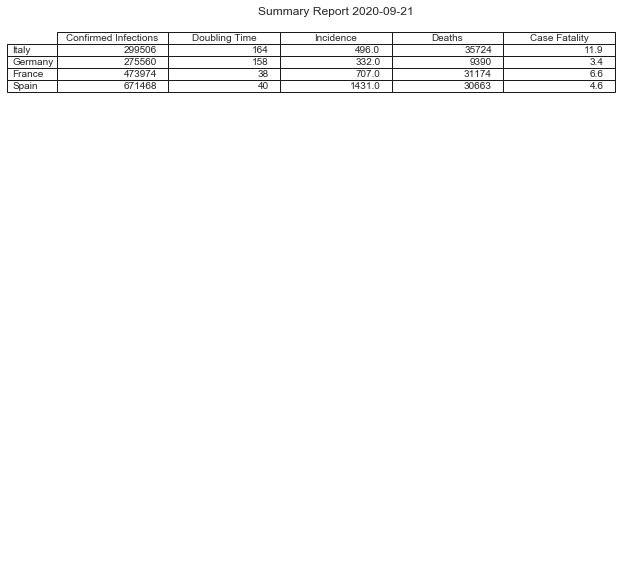

In [276]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(frame_on=False)
ax.axis('off')
ax.table(cellText=summary.values, rowLabels=summary.index, colLabels=summary.columns, loc='upper center')
plt.title('Summary Report ' + last_day)
plt.savefig('summary.png')